# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

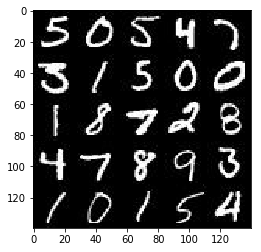

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

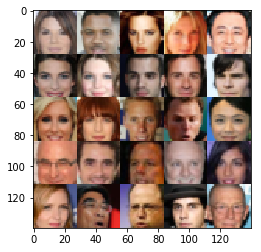

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Reset Graph

In [32]:
tf.reset_default_graph()

### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [33]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)    
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [34]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function                
    reuse = not is_train    
    
    with tf.variable_scope('generator', reuse=reuse):                    
        # First fully connected layer
        layer = tf.layers.dense(z, 7*7*256, activation=None, use_bias=False)
        # 7*7*256
        layer = tf.reshape(layer, (-1, 7, 7, 256))  # the 1th dimension should be -1
        layer = tf.layers.batch_normalization(layer, axis=-1, training=is_train)
        layer = tf.maximum(alpha * layer, layer)
                
        # 14*14*128
        layer = tf.layers.conv2d_transpose(layer, filters=128, kernel_size=5, strides=2, activation=None, use_bias=False, padding='same')
        layer = tf.layers.batch_normalization(layer, axis=-1, training=is_train)        
        layer = tf.maximum(alpha * layer, layer)

        # 14*14*64
        # Add one more layer with stride 1, to keep width and height and half depth
        layer = tf.layers.conv2d_transpose(layer, filters=64, kernel_size=5, strides=1, activation=None, use_bias=False, padding='same')
        layer = tf.layers.batch_normalization(layer, axis=-1, training=is_train)        
        layer = tf.maximum(alpha * layer, layer)        
        
        # 28*28*out_channel_dim
        logits = tf.layers.conv2d_transpose(layer, filters=out_channel_dim, kernel_size=5, strides=2, activation=None, use_bias=True, padding='same')
#         out = tf.tanh(logits)
        out = 0.5 * tf.tanh(logits)  # since the real images are scaled to [-0.5, 0.5]
        
        return out    
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [35]:
def discriminator(images, reuse=False, alpha=0.2, is_train=True):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28xout_channel_dim       
        # 14*14*64
        layer = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, activation=None, use_bias=True, padding='same')
        layer = tf.maximum(alpha * layer, layer)        

        # 7*7*128
        layer = tf.layers.conv2d(layer, filters=128, kernel_size=5, strides=2, activation=None, use_bias=False, padding='same')
        layer = tf.layers.batch_normalization(layer, axis=-1, training=is_train)        
        layer = tf.maximum(alpha * layer, layer)

        # 4*4*256
        layer = tf.layers.conv2d(layer, filters=256, kernel_size=5, strides=2, activation=None, use_bias=False, padding='same')
        layer = tf.layers.batch_normalization(layer, axis=-1, training=is_train)        
        layer = tf.maximum(alpha * layer, layer)
        
        layer = tf.reshape(layer, (-1, 4*4*256))                
#         layer = tf.layers.flatten(layer)                
        logits = tf.layers.dense(layer, 1, activation=None, use_bias=True)
        out = tf.sigmoid(logits)
                
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [36]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    
    # Rui: use label smoothing to improve performance
    smooth = 0.1    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, 
            labels=tf.ones_like(d_model_real) * (1 - smooth)  
        )
    )
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [37]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt        

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [38]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode, alpha=0.2):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, is_train=False, alpha=alpha),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [39]:
def train(epoch_count, batch_size, z_dim, learning_rate_val, beta1, get_batches, data_shape, data_image_mode, alpha=0.2, print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
#     tf.reset_default_graph()

    image_count, image_width, image_height, image_channels = data_shape
    input_real, input_z, learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, image_channels, alpha=alpha)

    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    
    losses = []
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
#                 print('epoch', epoch_i+1, 'steps', steps)
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate: learning_rate_val})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learning_rate: learning_rate_val})

#                 if steps % print_every == 0:                
                if (steps == 1) or (steps % print_every == 0):
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "steps", steps,
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

#                 if steps % show_every == 0:                    
                if (epoch_i == 0 and steps % 100 == 1) or (steps % show_every == 0):                
                    show_generator_output(sess, 5*5, input_z, image_channels, data_image_mode, alpha=alpha)
        
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [40]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

In [41]:
mnist_dataset.shape

(60000, 28, 28, 1)

In [42]:
image_count, image_width, image_height, image_channel = mnist_dataset.shape
image_width, image_height, image_channel

(28, 28, 1)

Epoch 1/2... steps 1 Discriminator Loss: 3.1581... Generator Loss: 0.1139


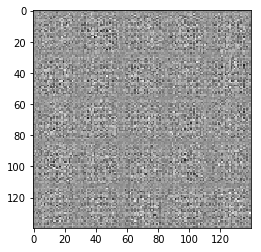

Epoch 1/2... steps 20 Discriminator Loss: 0.5004... Generator Loss: 2.2513
Epoch 1/2... steps 40 Discriminator Loss: 1.6434... Generator Loss: 6.5139
Epoch 1/2... steps 60 Discriminator Loss: 0.7087... Generator Loss: 1.8507
Epoch 1/2... steps 80 Discriminator Loss: 1.9468... Generator Loss: 0.2941
Epoch 1/2... steps 100 Discriminator Loss: 1.1288... Generator Loss: 0.7115


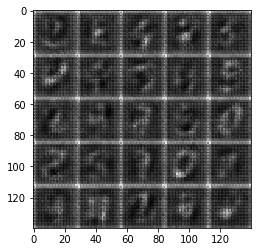

Epoch 1/2... steps 120 Discriminator Loss: 0.7408... Generator Loss: 1.3490
Epoch 1/2... steps 140 Discriminator Loss: 0.9802... Generator Loss: 0.8668
Epoch 1/2... steps 160 Discriminator Loss: 0.6966... Generator Loss: 1.6714
Epoch 1/2... steps 180 Discriminator Loss: 0.6759... Generator Loss: 1.4630
Epoch 1/2... steps 200 Discriminator Loss: 0.9491... Generator Loss: 0.8839


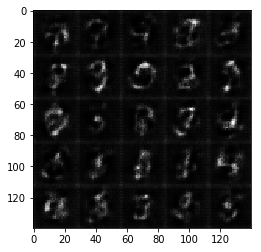

Epoch 1/2... steps 220 Discriminator Loss: 0.6567... Generator Loss: 1.5001
Epoch 1/2... steps 240 Discriminator Loss: 0.8487... Generator Loss: 2.8413
Epoch 1/2... steps 260 Discriminator Loss: 1.1749... Generator Loss: 0.6810
Epoch 1/2... steps 280 Discriminator Loss: 0.6181... Generator Loss: 1.7008
Epoch 1/2... steps 300 Discriminator Loss: 0.7395... Generator Loss: 1.2358


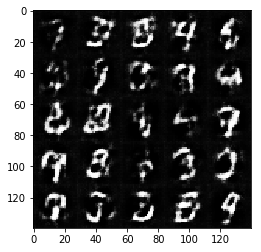

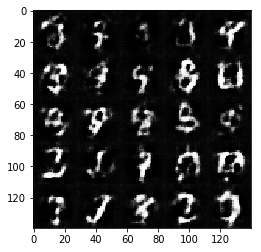

Epoch 1/2... steps 320 Discriminator Loss: 1.7064... Generator Loss: 4.7021
Epoch 1/2... steps 340 Discriminator Loss: 0.6260... Generator Loss: 1.6472
Epoch 1/2... steps 360 Discriminator Loss: 0.5881... Generator Loss: 2.2946
Epoch 1/2... steps 380 Discriminator Loss: 0.8048... Generator Loss: 2.7138
Epoch 1/2... steps 400 Discriminator Loss: 0.7018... Generator Loss: 1.4528


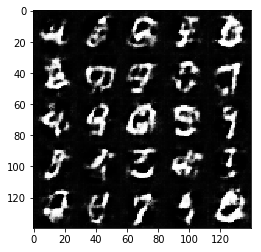

Epoch 1/2... steps 420 Discriminator Loss: 0.7348... Generator Loss: 1.3888
Epoch 1/2... steps 440 Discriminator Loss: 0.7603... Generator Loss: 1.3281
Epoch 1/2... steps 460 Discriminator Loss: 0.9426... Generator Loss: 2.6833
Epoch 2/2... steps 480 Discriminator Loss: 0.7305... Generator Loss: 1.7466
Epoch 2/2... steps 500 Discriminator Loss: 0.8001... Generator Loss: 1.8643
Epoch 2/2... steps 520 Discriminator Loss: 0.7755... Generator Loss: 1.7331
Epoch 2/2... steps 540 Discriminator Loss: 0.7356... Generator Loss: 1.3658
Epoch 2/2... steps 560 Discriminator Loss: 0.9227... Generator Loss: 0.9421
Epoch 2/2... steps 580 Discriminator Loss: 0.9920... Generator Loss: 2.4987
Epoch 2/2... steps 600 Discriminator Loss: 0.9227... Generator Loss: 0.9414


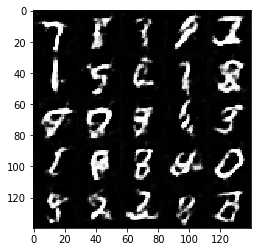

Epoch 2/2... steps 620 Discriminator Loss: 0.7495... Generator Loss: 1.6525
Epoch 2/2... steps 640 Discriminator Loss: 0.8976... Generator Loss: 1.2631
Epoch 2/2... steps 660 Discriminator Loss: 0.7825... Generator Loss: 1.2178
Epoch 2/2... steps 680 Discriminator Loss: 0.9606... Generator Loss: 0.8748
Epoch 2/2... steps 700 Discriminator Loss: 2.2994... Generator Loss: 3.9914
Epoch 2/2... steps 720 Discriminator Loss: 0.9452... Generator Loss: 0.9153
Epoch 2/2... steps 740 Discriminator Loss: 0.8847... Generator Loss: 0.9631
Epoch 2/2... steps 760 Discriminator Loss: 1.1003... Generator Loss: 0.7167
Epoch 2/2... steps 780 Discriminator Loss: 1.2617... Generator Loss: 0.5850
Epoch 2/2... steps 800 Discriminator Loss: 0.9521... Generator Loss: 1.1345
Epoch 2/2... steps 820 Discriminator Loss: 0.7258... Generator Loss: 1.4055
Epoch 2/2... steps 840 Discriminator Loss: 0.7161... Generator Loss: 1.6447
Epoch 2/2... steps 860 Discriminator Loss: 1.1435... Generator Loss: 0.7086
Epoch 2/2...

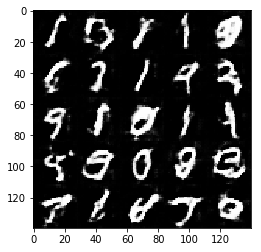

Epoch 2/2... steps 920 Discriminator Loss: 1.7539... Generator Loss: 0.3637


In [43]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
        mnist_dataset.shape, mnist_dataset.image_mode, 
        alpha=alpha, print_every=20, show_every=300)

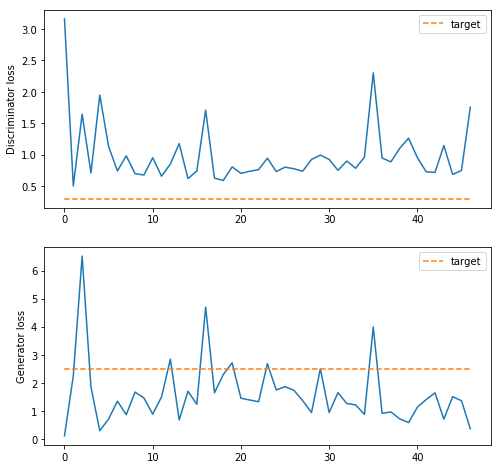

In [44]:
%matplotlib inline

import matplotlib.pyplot as plt

losses = np.array(losses)

fig, axes = plt.subplots(2, 1, figsize=(8,8),)
ylabels = ['Discriminator loss', 'Generator loss']
targets = [0.3, 2.5]
for i, ax in zip([0, 1], axes.flatten()):
    ax.plot(losses.T[i])
    ax.plot([targets[i]] * len(losses.T[i]), label='target', linestyle='--')    
    ax.set_ylabel(ylabels[i])
    ax.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

celeba_dataset.shape (202599, 28, 28, 3)
Epoch 1/1... steps 1 Discriminator Loss: 3.1497... Generator Loss: 0.0837


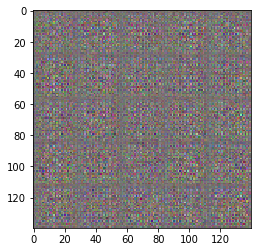

Epoch 1/1... steps 20 Discriminator Loss: 0.5950... Generator Loss: 2.1725
Epoch 1/1... steps 40 Discriminator Loss: 0.5941... Generator Loss: 2.6599
Epoch 1/1... steps 60 Discriminator Loss: 0.7981... Generator Loss: 2.0887
Epoch 1/1... steps 80 Discriminator Loss: 1.0566... Generator Loss: 1.6360
Epoch 1/1... steps 100 Discriminator Loss: 1.1831... Generator Loss: 2.2201


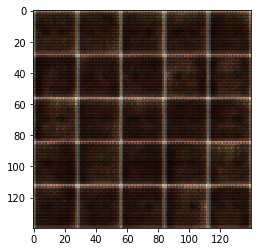

Epoch 1/1... steps 120 Discriminator Loss: 0.9188... Generator Loss: 2.2225
Epoch 1/1... steps 140 Discriminator Loss: 0.8584... Generator Loss: 1.2761
Epoch 1/1... steps 160 Discriminator Loss: 0.9135... Generator Loss: 1.7580
Epoch 1/1... steps 180 Discriminator Loss: 1.0351... Generator Loss: 1.2466
Epoch 1/1... steps 200 Discriminator Loss: 0.9779... Generator Loss: 1.0059


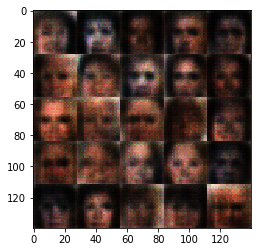

Epoch 1/1... steps 220 Discriminator Loss: 0.9878... Generator Loss: 0.9463
Epoch 1/1... steps 240 Discriminator Loss: 1.8107... Generator Loss: 0.3509
Epoch 1/1... steps 260 Discriminator Loss: 0.9994... Generator Loss: 1.0759
Epoch 1/1... steps 280 Discriminator Loss: 1.1519... Generator Loss: 2.4747
Epoch 1/1... steps 300 Discriminator Loss: 1.1876... Generator Loss: 0.9032


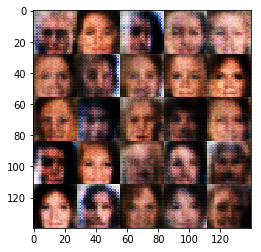

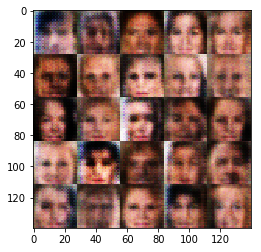

Epoch 1/1... steps 320 Discriminator Loss: 1.0257... Generator Loss: 1.2746
Epoch 1/1... steps 340 Discriminator Loss: 1.3964... Generator Loss: 0.6776
Epoch 1/1... steps 360 Discriminator Loss: 1.1782... Generator Loss: 1.6436
Epoch 1/1... steps 380 Discriminator Loss: 1.1653... Generator Loss: 0.8644
Epoch 1/1... steps 400 Discriminator Loss: 1.3550... Generator Loss: 0.6145


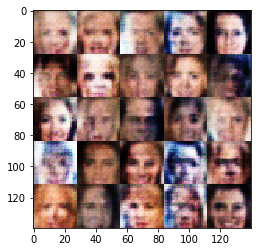

Epoch 1/1... steps 420 Discriminator Loss: 1.2788... Generator Loss: 1.6487
Epoch 1/1... steps 440 Discriminator Loss: 1.3080... Generator Loss: 0.6216
Epoch 1/1... steps 460 Discriminator Loss: 1.2985... Generator Loss: 1.5604
Epoch 1/1... steps 480 Discriminator Loss: 1.3652... Generator Loss: 0.5861
Epoch 1/1... steps 500 Discriminator Loss: 1.6864... Generator Loss: 0.3683


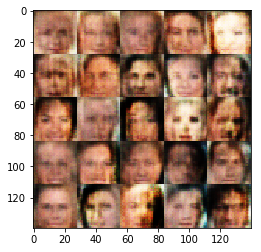

Epoch 1/1... steps 520 Discriminator Loss: 1.1700... Generator Loss: 0.7609
Epoch 1/1... steps 540 Discriminator Loss: 1.0480... Generator Loss: 1.1338
Epoch 1/1... steps 560 Discriminator Loss: 1.1838... Generator Loss: 0.7683
Epoch 1/1... steps 580 Discriminator Loss: 1.1275... Generator Loss: 0.9834
Epoch 1/1... steps 600 Discriminator Loss: 1.0803... Generator Loss: 0.8033


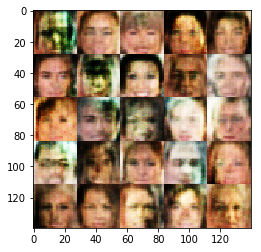

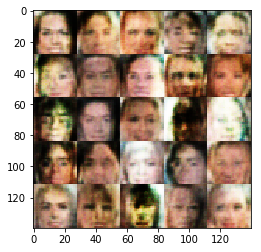

Epoch 1/1... steps 620 Discriminator Loss: 1.1413... Generator Loss: 0.7358
Epoch 1/1... steps 640 Discriminator Loss: 0.8556... Generator Loss: 1.2664
Epoch 1/1... steps 660 Discriminator Loss: 1.0056... Generator Loss: 1.3141
Epoch 1/1... steps 680 Discriminator Loss: 0.7659... Generator Loss: 2.3640
Epoch 1/1... steps 700 Discriminator Loss: 1.0601... Generator Loss: 0.7329


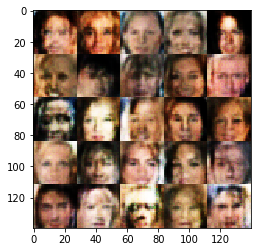

Epoch 1/1... steps 720 Discriminator Loss: 0.6964... Generator Loss: 1.6199
Epoch 1/1... steps 740 Discriminator Loss: 0.5154... Generator Loss: 2.2982
Epoch 1/1... steps 760 Discriminator Loss: 1.3431... Generator Loss: 4.8880
Epoch 1/1... steps 780 Discriminator Loss: 1.3566... Generator Loss: 3.7118
Epoch 1/1... steps 800 Discriminator Loss: 0.7348... Generator Loss: 5.7349


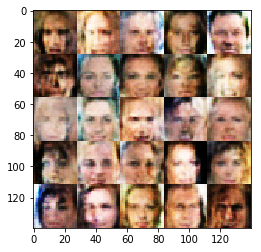

Epoch 1/1... steps 820 Discriminator Loss: 0.4902... Generator Loss: 2.8761
Epoch 1/1... steps 840 Discriminator Loss: 0.4625... Generator Loss: 2.6331
Epoch 1/1... steps 860 Discriminator Loss: 0.8897... Generator Loss: 9.4278
Epoch 1/1... steps 880 Discriminator Loss: 0.4028... Generator Loss: 3.1141
Epoch 1/1... steps 900 Discriminator Loss: 0.7064... Generator Loss: 1.3386


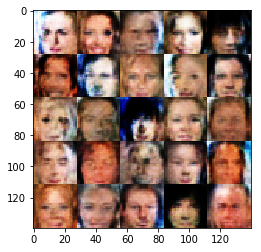

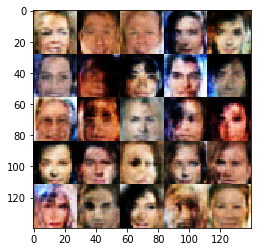

Epoch 1/1... steps 920 Discriminator Loss: 0.4654... Generator Loss: 2.9556
Epoch 1/1... steps 940 Discriminator Loss: 1.3634... Generator Loss: 4.4289
Epoch 1/1... steps 960 Discriminator Loss: 0.5289... Generator Loss: 2.2117
Epoch 1/1... steps 980 Discriminator Loss: 0.9173... Generator Loss: 0.8987
Epoch 1/1... steps 1000 Discriminator Loss: 0.5809... Generator Loss: 1.7192


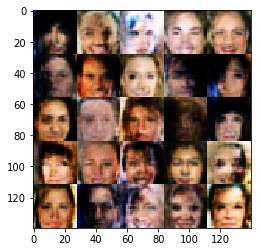

Epoch 1/1... steps 1020 Discriminator Loss: 0.7041... Generator Loss: 1.2866
Epoch 1/1... steps 1040 Discriminator Loss: 0.4271... Generator Loss: 2.6410
Epoch 1/1... steps 1060 Discriminator Loss: 1.4887... Generator Loss: 0.4371
Epoch 1/1... steps 1080 Discriminator Loss: 0.7223... Generator Loss: 3.3494
Epoch 1/1... steps 1100 Discriminator Loss: 0.4403... Generator Loss: 2.5026


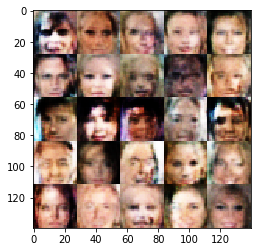

Epoch 1/1... steps 1120 Discriminator Loss: 0.7789... Generator Loss: 1.1140
Epoch 1/1... steps 1140 Discriminator Loss: 1.0465... Generator Loss: 0.7917
Epoch 1/1... steps 1160 Discriminator Loss: 0.4717... Generator Loss: 2.7225
Epoch 1/1... steps 1180 Discriminator Loss: 0.3584... Generator Loss: 4.8765
Epoch 1/1... steps 1200 Discriminator Loss: 0.6358... Generator Loss: 1.5902


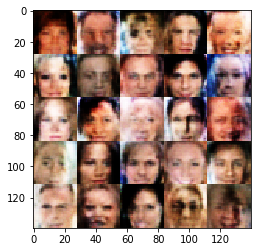

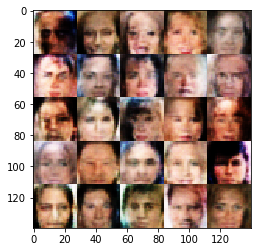

Epoch 1/1... steps 1220 Discriminator Loss: 0.6326... Generator Loss: 1.5638
Epoch 1/1... steps 1240 Discriminator Loss: 0.6016... Generator Loss: 1.6104
Epoch 1/1... steps 1260 Discriminator Loss: 0.4433... Generator Loss: 3.9407
Epoch 1/1... steps 1280 Discriminator Loss: 0.3917... Generator Loss: 3.2230
Epoch 1/1... steps 1300 Discriminator Loss: 1.2310... Generator Loss: 4.0901


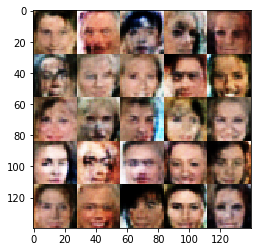

Epoch 1/1... steps 1320 Discriminator Loss: 0.6673... Generator Loss: 1.5284
Epoch 1/1... steps 1340 Discriminator Loss: 0.5726... Generator Loss: 1.7318
Epoch 1/1... steps 1360 Discriminator Loss: 0.6357... Generator Loss: 1.4368
Epoch 1/1... steps 1380 Discriminator Loss: 0.3940... Generator Loss: 3.1569
Epoch 1/1... steps 1400 Discriminator Loss: 0.4462... Generator Loss: 2.4853


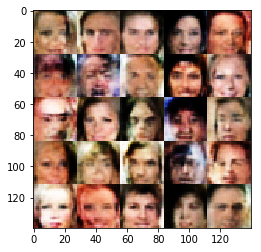

Epoch 1/1... steps 1420 Discriminator Loss: 0.6744... Generator Loss: 1.3717
Epoch 1/1... steps 1440 Discriminator Loss: 0.4204... Generator Loss: 2.7971
Epoch 1/1... steps 1460 Discriminator Loss: 0.3556... Generator Loss: 4.3838
Epoch 1/1... steps 1480 Discriminator Loss: 2.8990... Generator Loss: 0.1379
Epoch 1/1... steps 1500 Discriminator Loss: 1.0093... Generator Loss: 2.4142


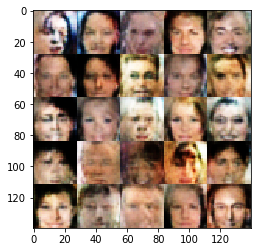

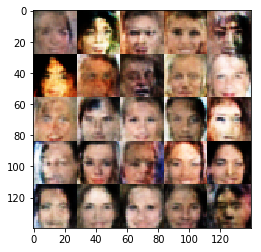

Epoch 1/1... steps 1520 Discriminator Loss: 0.5546... Generator Loss: 2.2746
Epoch 1/1... steps 1540 Discriminator Loss: 0.5854... Generator Loss: 1.6421
Epoch 1/1... steps 1560 Discriminator Loss: 0.4117... Generator Loss: 2.8842
Epoch 1/1... steps 1580 Discriminator Loss: 0.7029... Generator Loss: 3.2821


In [45]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
print('celeba_dataset.shape', celeba_dataset.shape)

with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode,
          alpha=alpha, print_every=20, show_every=300)

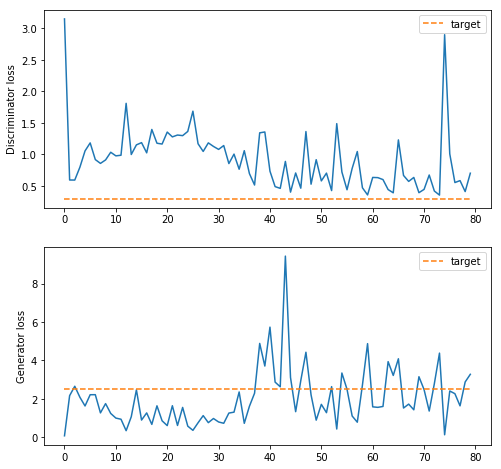

In [46]:
%matplotlib inline

import matplotlib.pyplot as plt

losses = np.array(losses)

fig, axes = plt.subplots(2, 1, figsize=(8,8),)
ylabels = ['Discriminator loss', 'Generator loss']
targets = [0.3, 2.5]
for i, ax in zip([0, 1], axes.flatten()):
    ax.plot(losses.T[i])
    ax.plot([targets[i]] * len(losses.T[i]), label='target', linestyle='--')    
    ax.set_ylabel(ylabels[i])
    ax.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.